In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [ ]:
with_mask_dir=r'../dataset/with_mask'
without_mask_dir=r'../dataset/without_mask'
filepaths = []
labels= []
dict_list = [with_mask_dir, without_mask_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('with_mask')
        else:
          labels.append('without_mask') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
mask_data = pd.concat([Fseries,Lseries], axis=1)
mask_df = pd.DataFrame(mask_data)
print(mask_df.head())
print(mask_df["labels"].value_counts())

                                 filepaths     labels
0     ../dataset/with_mask\with_mask_1.jpg  with_mask
1    ../dataset/with_mask\with_mask_10.jpg  with_mask
2   ../dataset/with_mask\with_mask_100.jpg  with_mask
3  ../dataset/with_mask\with_mask_1000.jpg  with_mask
4  ../dataset/with_mask\with_mask_1001.jpg  with_mask
without_mask    3828
with_mask       3725
Name: labels, dtype: int64


In [ ]:
#shape of datatset
mask_df.shape

(7553, 2)

In [ ]:
train_set, test_images = train_test_split(mask_df, test_size=0.3, random_state=42)
test_set, val_set = train_test_split(test_images, test_size=0.2, random_state=42)

In [ ]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='grayscale',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )

test = image_gen.flow_from_dataframe(dataframe= test_set,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='grayscale',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'grayscale',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['with_mask', 'without_mask']


In [ ]:
def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

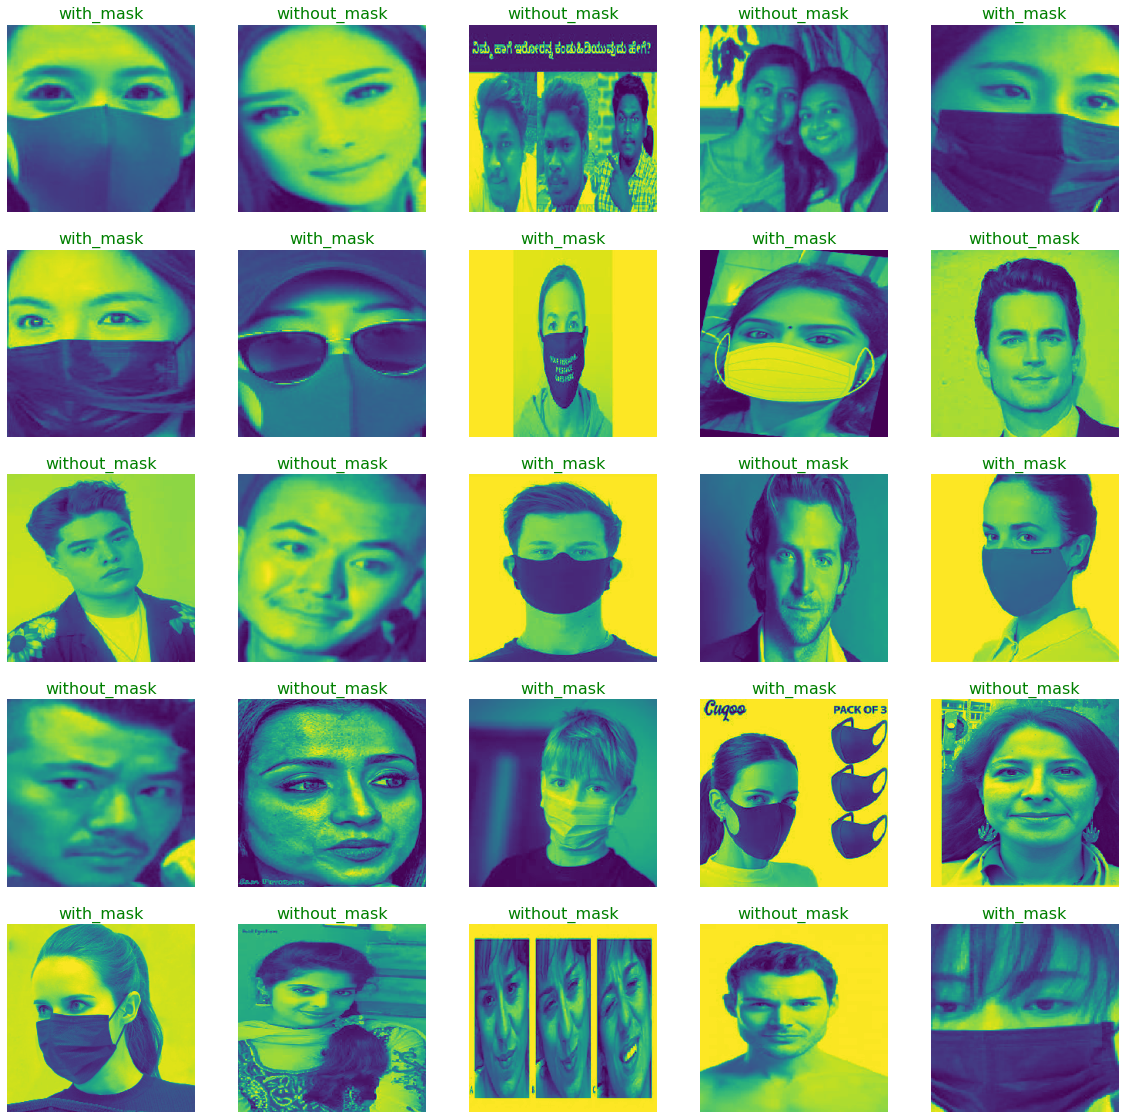

In [ ]:
show_images(train)

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    history_df.loc[0:, ['loss', 'val_loss']].plot()
    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

# Model #1

In [ ]:
import keras
from tensorflow.keras import layers

CNN_2 = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(244,244,1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

CNN_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
CNN_2.optimizer.lr=0.001
history_CNN = CNN_2.fit(train, validation_data= val, epochs=2,verbose=1)

CNN_2.summary()

Epoch 1/2
166/166 [==============================] - 206s 1s/step - loss: 0.6380 - accuracy: 0.6379 - val_loss: 0.3686 - val_accuracy: 0.8436
Epoch 2/2
166/166 [==============================] - 207s 1s/step - loss: 0.3497 - accuracy: 0.8504 - val_loss: 0.2846 - val_accuracy: 0.8656
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_44 (ModuleWra (None, None, None, 32)    320       
_________________________________________________________________
module_wrapper_45 (ModuleWra (None, None, None, 32)    0         
_________________________________________________________________
module_wrapper_46 (ModuleWra (None, None, None, 64)    18496     
_________________________________________________________________
module_wrapper_47 (ModuleWra (None, None, None, 64)    0         
_________________________________________________________________
module_wrapper_48 (ModuleWra (None

In [ ]:
history_CNN = CNN_2.fit(train, validation_data= val, epochs=2,verbose=1)

Epoch 1/2
166/166 [==============================] - 192s 1s/step - loss: 0.2544 - accuracy: 0.8998 - val_loss: 0.2312 - val_accuracy: 0.9075
Epoch 2/2
166/166 [==============================] - 192s 1s/step - loss: 0.1827 - accuracy: 0.9268 - val_loss: 0.2076 - val_accuracy: 0.9141


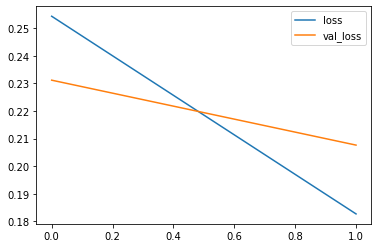

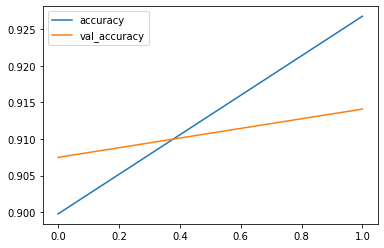

In [ ]:
#resuts from model 1
plot_loss_and_accuracy(history_CNN.history)

The above charts show the accuracy and loss for the training set and test set. In the loss chart we see the test set in orange stabilize much faster than the training loss. This same behavior is seen in the accuracy chart. This shows there exists some overfitting in the model. Next, I will adjust the parameters in the second model to overcome the overfitting.

In [ ]:
pred = CNN_2.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

   with_mask       0.92      0.93      0.92       889
without_mask       0.93      0.92      0.93       923

    accuracy                           0.92      1812
   macro avg       0.92      0.92      0.92      1812
weighted avg       0.92      0.92      0.92      1812



# Model #2

In [ ]:
from tensorflow.keras import layers

MyCnn = tf.keras.models.Sequential([
  layers.Conv2D(32, 3, activation='relu',input_shape=(244,244,1)),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

MyCnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

MyCnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 242, 242, 32)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 57, 57, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0

In [ ]:
history_my_CNN = MyCnn.fit(train, validation_data= val, epochs=2,verbose=1)

Epoch 1/2
166/166 [==============================] - 229s 1s/step - loss: 0.6708 - accuracy: 0.5807 - val_loss: 0.6138 - val_accuracy: 0.6718
Epoch 2/2
166/166 [==============================] - 216s 1s/step - loss: 0.6128 - accuracy: 0.6457 - val_loss: 0.5753 - val_accuracy: 0.7070


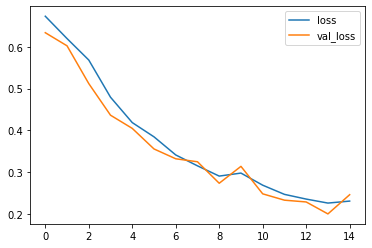

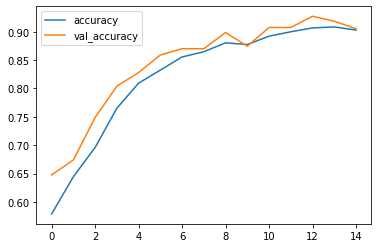

In [ ]:
plot_loss_and_accuracy(history_my_CNN.history)

The above charts show the accuracy and loss for the training set and test set for the second model. In the loss chart we see the test set in orange stabilizes at about the same rate as the training loss in blue. Although we have overcome overfitting, the accuracy of this model#2 is similar to model#1. The similarities can also seen in the confusion matricies below.

# Confustion Matrix

In [ ]:
pred_mod2 = MyCnn.predict(test)
pred_mod2 = np.argmax(pred_mod2, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2_mod2 = [labels[k] for k in pred_mod2]

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2_mod2))

              precision    recall  f1-score   support

   with_mask       0.80      0.98      0.88       889
without_mask       0.97      0.77      0.86       923

    accuracy                           0.87      1812
   macro avg       0.89      0.87      0.87      1812
weighted avg       0.89      0.87      0.87      1812



<AxesSubplot:>

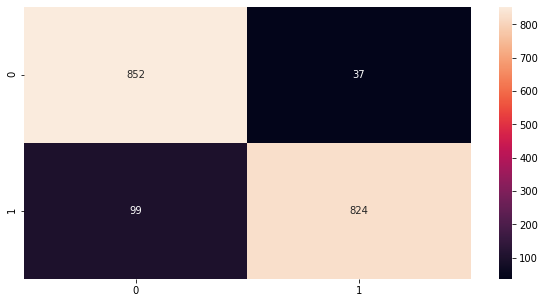

In [ ]:
# model 1
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

<AxesSubplot:>

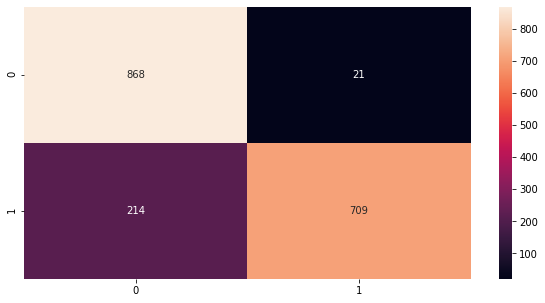

In [ ]:
# model 2
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2_mod2)
sns.heatmap(cm, annot=True, fmt = 'g')

A special thanks to the following notebooks:

* [Brain Tumor Classification- 98.4% Accuracy](https://www.kaggle.com/purvitsharma/brain-tumor-classification-98-4-accuracy) - [Purvit Vashishtha](https://www.kaggle.com/purvitsharma)
* [CnnForMaskDetection(Improved:Size and Performance)](https://www.kaggle.com/vanvalkenberg/cnnformaskdetection-improved-size-and-performance) - [Ritwek Khosla](https://www.kaggle.com/vanvalkenberg)